# Introduction to CNN Keras
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


## read data

In [2]:
train = pd.read_csv('./data/Introduction_to_CNN_Keras/train.csv')
test = pd.read_csv('./data/Introduction_to_CNN_Keras/test.csv')

In [3]:
train.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  pixel9  pixel10  pixel11  pixel12  pixel13  pixel14  pixel15  \
0       0       0        0        0        0        0        0        0   
1       0       0        0        0        0        0        0        0   
2       0       0        0        0        0        0        0        0   
3       0       0        0        0        0        0        0        0   
4       0       0        0        0        0        0        0        0   

   pixel16  pixel17  pixel18  pixel19  pixel20  pixel21  pixel22  pixel23  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel24  pixel25  pixel26  pixel27  pixel28  pixel29  pixel30  pixel31  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel32  pixel33  pixel34  pixel35  pixel36  pixel37  pixel38  pixel39  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel40  pixel41  pixel42  pixel43  pixel44  pixel45  pixel46  pixel47  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel48    ...     pixel734  pixel735  pixel736  pixel737  pixel738  \
0        0    ...            0         0         0         0         0   
1        0    ...            0         0         0         0         0   
2        0    ...            0         0         0         0         0   
3        0    ...            0         0         0         0         0   
4        0    ...            0         0         0         0         0   

   pixel739  pixel740  pixel741  pixel742  pixel743  pixel744  pixel745  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   pixel746  pixel747  pixel748  pixel749  pixel750  pixel751  pixel752  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0      

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

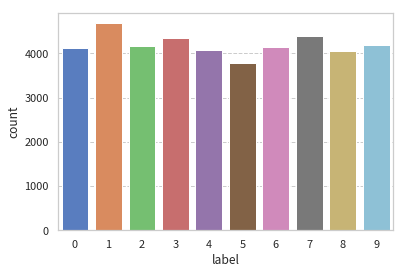

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels=["label"], axis=1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

## check for null and missing values

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## normalization


In [7]:
X_train = X_train / 255.0
test = test / 255.0

## reshape

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## label encoding

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

## split train and test

In [10]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=random_seed)

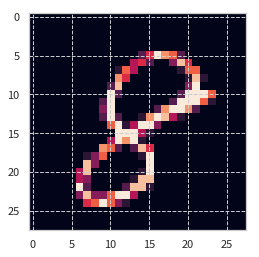

In [11]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# CNN

## define model

In [34]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D ->
# Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

# https://keras.io/ja/layers/convolutional/

# Sequentialモデル: レイヤーを積み重ねたモデル. add()でレイヤーを追加する.
model = Sequential()

# Convolution層の追加
# (参考) paddingオプションのvalid, sameによる出力サイズの違い
#  valid
#       out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
#       out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
#  same 
#       out_height = ceil(float(in_height) / float(strides[1]))
#       out_width  = ceil(float(in_width) / float(strides[2]))
model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding='Same',      #パディングのタイプ(valid:パディングしない, same:元の入力と同じ長さにパディング(by 0?))
        activation='relu',   #活性化関数をreluにする
        input_shape=(28, 28, 1)))
# Convolution層の追加
model.add(
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
# Pooling層の追加(MaxPooling)
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout: 前の層のノードのうち、いくつかを無効にして学習する. 一般には50%程度を無効にするとよいらしい.
model.add(Dropout(0.25))

model.add(
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Flatten: 入力を平滑化する(ig.(None, 64,32,32)->(None, 65536))
model.add(Flatten())
# Dence: 全結合
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

## set the optimizer and annealer

In [35]:
# RMSprop: Adagradを改良した勾配法アルゴリズムのひとつ. 
# SGDよりはやい. 
# https://qiita.com/tokkuman/items/1944c00415d129ca0ee9
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [36]:
# complie the model
# compile: 学習処理を設定する.
#  "optimizer"    最適化手法
#  "loss"         損失関数. 最小化しようとする目的関数. 定義されているものを文字列として与えるか、自作関数を与えられる.
#  "metrics"      評価関数のリスト.
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
# set a learning rate annealer
# ReduceLROnPlateau: コールバックのひとつ. 評価値の改善が止まったときに、学習率をへらす.
#  "patience" 何エポック改善が見られなかったら学習率をへらすか
#  "factor"   学習率をへらす割合
#  "min_lr"   学習率の下限
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [42]:
epochs = 5
batch_size = 86

## data augmentation
過学習を避けるために、学習データを拡張するテクニックがある(ラベルはそのまま).  
グレイスケールにする、x方向にずらす、y方向にずらす、ランダムにトリムする、カラージッタ(?)、翻訳(?)、回転、etc.  


In [43]:
# with data augmentation to prevent overfitting
# https://keras.io/ja/preprocessing/image/#imagedatagenerator
datagen = ImageDataGenerator(
    featurewise_center=False,   #データセット全体で入力の平均を0にする
    samplewise_center=False,    #各サンプルの平均を0にする
    featurewise_std_normalization=False,   #入力をデータセットの標準偏差で正規化する
    samplewise_std_normalization=False,    #各入力を標準偏差で正規化する
    zca_whitening=False,        #ZCA白色化を適用する
    rotation_range=10,          #回転範囲
    zoom_range=0.1,             #ズームする範囲
    width_shift_range=0.1,      #水平シフトする範囲
    height_shift_range=0.1,     #垂直シフトする範囲
    horizontal_flip=False,      #水平方向に入力をランダムに反転する
    vertical_flip=False)        #垂直方向に入力をランダムに反転する

In [44]:
datagen.fit(X_train)

In [45]:
datagen

In [46]:
# fit the model

# fit_generator: Pythonジェネレータによりバッチ毎に生成されたデータでモデルを訓練します．
history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction])

Epoch 1/5
 - 147s - loss: 0.1810 - acc: 0.9480 - val_loss: 0.0909 - val_acc: 0.9745
Epoch 2/5
 - 151s - loss: 0.1310 - acc: 0.9640 - val_loss: 0.0387 - val_acc: 0.9879
Epoch 3/5
 - 121s - loss: 0.1011 - acc: 0.9711 - val_loss: 0.0362 - val_acc: 0.9907
Epoch 4/5
 - 124s - loss: 0.0865 - acc: 0.9747 - val_loss: 0.0333 - val_acc: 0.9890
Epoch 5/5
 - 125s - loss: 0.0798 - acc: 0.9770 - val_loss: 0.0332 - val_acc: 0.9900


# Evaluate the model

## training and validation curves

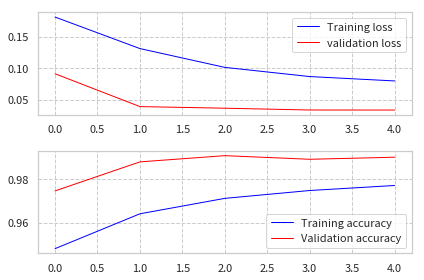

In [47]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(
    history.history['val_loss'],
    color='r',
    label="validation loss",
    axes=ax[0])
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best')
fig.tight_layout()

In [48]:
history.history

{'val_loss': [0.09093682763737715,
  0.038738148811306536,
  0.0361696570450052,
  0.033306071315448556,
  0.03323943126575268],
 'val_acc': [0.9745237998167674,
  0.9878571370669774,
  0.9907142812865121,
  0.9890476138251169,
  0.9899999952316284],
 'loss': [0.18111207330290352,
  0.13097781916198842,
  0.10108425562731424,
  0.08648063384463135,
  0.07952141977499716],
 'acc': [0.948003389305974,
  0.9640186559409891,
  0.9710982551236873,
  0.9747043431560656,
  0.9770111801857317],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

## confusion matrix

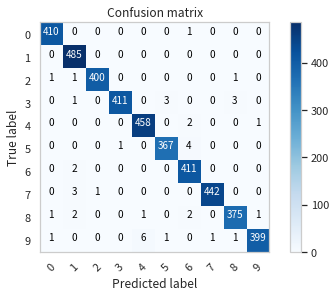

In [49]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

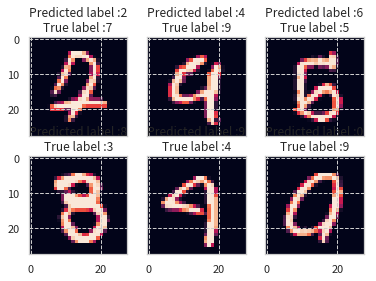

In [50]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

\begin{equation}
\(E[g^2]_t = \gamma E[g^2]_{t-1} + (1 – \gamma) g^2_t \) \\
\(\Delta \theta_t = – \eta \cdot g_{t, i}\) \\
\(\theta_{t+1} = \theta_t + \Delta \theta_t \) \\
\( \Delta \theta_t = – \dfrac{\eta}{\sqrt{G_{t} + \epsilon}} \odot g_{t}\) \\
\( \Delta \theta_t = – \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}\) \\
\( \Delta \theta_t = – \dfrac{\eta}{RMS[g]_{t}}\) \\
\(E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1 – \gamma) \Delta \theta^2_t \) \\
\(RMS[\Delta \theta]_{t} = \sqrt{E[\Delta \theta^2]_t + \epsilon} \) \\
\( \Delta \theta_t = – \dfrac{RMS[\Delta \theta]_{t-1}}{RMS[g]_{t}} g_{t}\). \\
\(\theta_{t+1} = \theta_t + \Delta \theta_t \)
\end{equation}